# Shapelet Discovery

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import stumpy
import os
os.environ["NUMBA_NUM_THREADS"] = "19"
os.environ["OMP_NUM_THREADS"]="19"

In [4]:
echo %NUMBER_OF_PROCESSORS%

24


In [5]:
short_ts = np.random.rand(2**12)
long_ts = np.random.rand(2**20) 

In [6]:
#start = time.time()
#mp = stumpy.gpu_stump(short_ts, 50, ignore_trivial=True)
#print(time.time()-start)

In [7]:
train = pd.read_csv("labelled_training_data.csv")

In [8]:
testing = pd.read_csv("labelled_testing_data.csv")
val = pd.read_csv("labelled_validation_data.csv")

In [9]:
data = pd.concat([train, testing, val])

In [10]:
data = data.sort_values(by=['timestamp'])

In [11]:
data = data.set_index("timestamp")

In [12]:
data.columns

Index(['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace',
       'processName', 'hostName', 'eventId', 'eventName', 'stackAddresses',
       'argsNum', 'returnValue', 'args', 'sus', 'evil'],
      dtype='object')

In [13]:
data

,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
timestamp,,,,,,,,,,,,,,,
124.439221,381,381,1,101,4026532232,systemd-resolve,ip-10-100-1-129,41,socket,"[139913106282763, 139913103116537, 94901962555...",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
124.439751,378,378,1,100,4026532231,systemd-network,ip-10-100-1-129,41,socket,"[140343254628619, 93967981149065, 93967990898192]",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
124.439958,1,1,0,0,4026531840,systemd,ip-10-100-1-129,1005,security_file_open,"[140074839310116, 8103505641674583864]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
124.440007,1,1,0,0,4026531840,systemd,ip-10-100-1-129,257,openat,[],4,12,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
124.440037,1,1,0,0,4026531840,systemd,ip-10-100-1-129,5,fstat,[140074839307913],2,0,"[{'name': 'fd', 'type': 'int', 'value': 12}, {...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954.587254,1,1,0,0,4026531840,systemd,ip-10-100-1-120,257,openat,[],4,39,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
3954.587429,1,1,0,0,4026531840,systemd,ip-10-100-1-120,5,fstat,[],2,0,"[{'name': 'fd', 'type': 'int', 'value': 39}, {...",0,0
3954.587480,1,1,0,0,4026531840,systemd,ip-10-100-1-120,217,getdents64,[],3,576,"[{'name': 'fd', 'type': 'int', 'value': 39}, {...",0,0


In [14]:
data["processId"] = data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
data["parentProcessId"] = data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
data["userId"] = data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
data["mountNamespace"] = data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
data["eventId"] = data["eventId"]  # Keep eventId values (requires knowing max value)
data["returnValue"] = data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

In [15]:
data["eventId"].unique()

array([  41, 1005,  257,    5,    3, 1006,   87, 1003,  114,  113,   42,
         51,  288,   21, 1010,   49,    6,  217,    4,   56,   91,  157,
         62,  292,   33,   59, 1004,  263,  166,   43,   32,  106,  105,
         88,  165,   94,  133,  260,   90,  321,  319,   50,  269,  123,
        122,    2], dtype=int64)

In [16]:
 #from sklearn.preprocessing import MinMaxScaler

In [17]:
#scaler = MinMaxScaler(feature_range=(0,1))

In [18]:
#old_shape = data['eventId'].shape

In [19]:
#data['eventId'] = scaler.fit_transform(data['eventId'].to_numpy().reshape(-1,1)).reshape(old_shape)

In [20]:
#data['eventId'].unique()

In [21]:
dataset = data[['processId', 'parentProcessId','userId','mountNamespace','eventId','argsNum','returnValue', 'sus']]

In [22]:
dataset

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus
timestamp,,,,,,,,
124.439221,1,0,0,1,41,3,1,0
124.439751,1,0,0,1,41,3,1,0
124.439958,0,0,0,0,1005,4,0,0
124.440007,0,0,0,0,257,4,1,0
124.440037,0,0,0,0,5,2,0,0
...,...,...,...,...,...,...,...,...
3954.587254,0,0,0,0,257,4,1,0
3954.587429,0,0,0,0,5,2,0,0
3954.587480,0,0,0,0,217,3,1,0


In [23]:
dataset.isna().sum()

processId          0
parentProcessId    0
userId             0
mountNamespace     0
eventId            0
argsNum            0
returnValue        0
sus                0
dtype: int64

In [24]:
dataset['sus'].value_counts()

sus
0    967564
1    173514
Name: count, dtype: int64

In [25]:
dataset = dataset.reset_index()

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_19276\434335537.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts_notsus = dataset[dataset['sus']==0].groupby(bins).size()
C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_19276\434335537.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts_sus = dataset[dataset['sus']==1].groupby(bins).size()


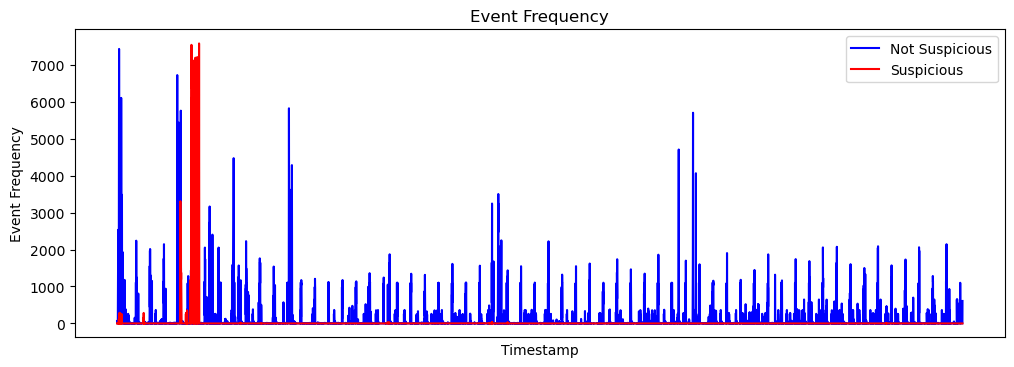

In [26]:
bins = pd.cut(dataset['timestamp'], bins=10000)
event_counts_notsus = dataset[dataset['sus']==0].groupby(bins).size()
event_counts_sus = dataset[dataset['sus']==1].groupby(bins).size()
event_counts_notsus.plot(kind='line', color='blue', label='Not Suspicious', figsize=(12, 4))
event_counts_sus.plot(kind='line', color='red', label='Suspicious')
plt.xlabel('Timestamp')
plt.ylabel('Event Frequency')
plt.title('Event Frequency')
plt.xticks([])
plt.legend()
plt.show()

In [27]:
def merge_sequences(df):
    return df.assign(
        # create a new col called separator with only NaNs
        separator=np.nan
        # create a stack series and convert it back into a dataframe with the cxorrect formatting
        ).stack(dropna=False).to_frame().reset_index(drop=True).rename({0: "centroid"}, axis=1)

In [28]:
sus = merge_sequences(dataset[dataset['sus']==1])

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_19276\1375280662.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return df.assign(


In [29]:
notsus = merge_sequences(dataset[dataset['sus']==0])

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_19276\1375280662.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return df.assign(


In [30]:
#fig, ax = plt.subplots(2,figsize=(24,8),sharex=True)
#ax[0].set_title('OS')
#ax[0].plot(OS)
#ax[1].set_title('Not_OS')
#ax[1].plot(Not_OS)

In [31]:
sus

,centroid
0,128.548679
1,1.000000
2,1.000000
3,1.000000
4,0.000000
...,...
1735135,4.000000
1735136,2.000000
1735137,0.000000
1735138,1.000000


In [32]:
sus.isna().sum()

centroid    173514
dtype: int64

In [33]:
sus['centroid'] = sus['centroid'].fillna(sus['centroid'].mean())

In [34]:
sus.isna().sum()

centroid    0
dtype: int64

In [35]:
notsus.isna().sum()

centroid    967564
dtype: int64

In [36]:
notsus['centroid'] = notsus['centroid'].fillna(notsus['centroid'].mean())

In [37]:
notsus.isna().sum()

centroid    0
dtype: int64

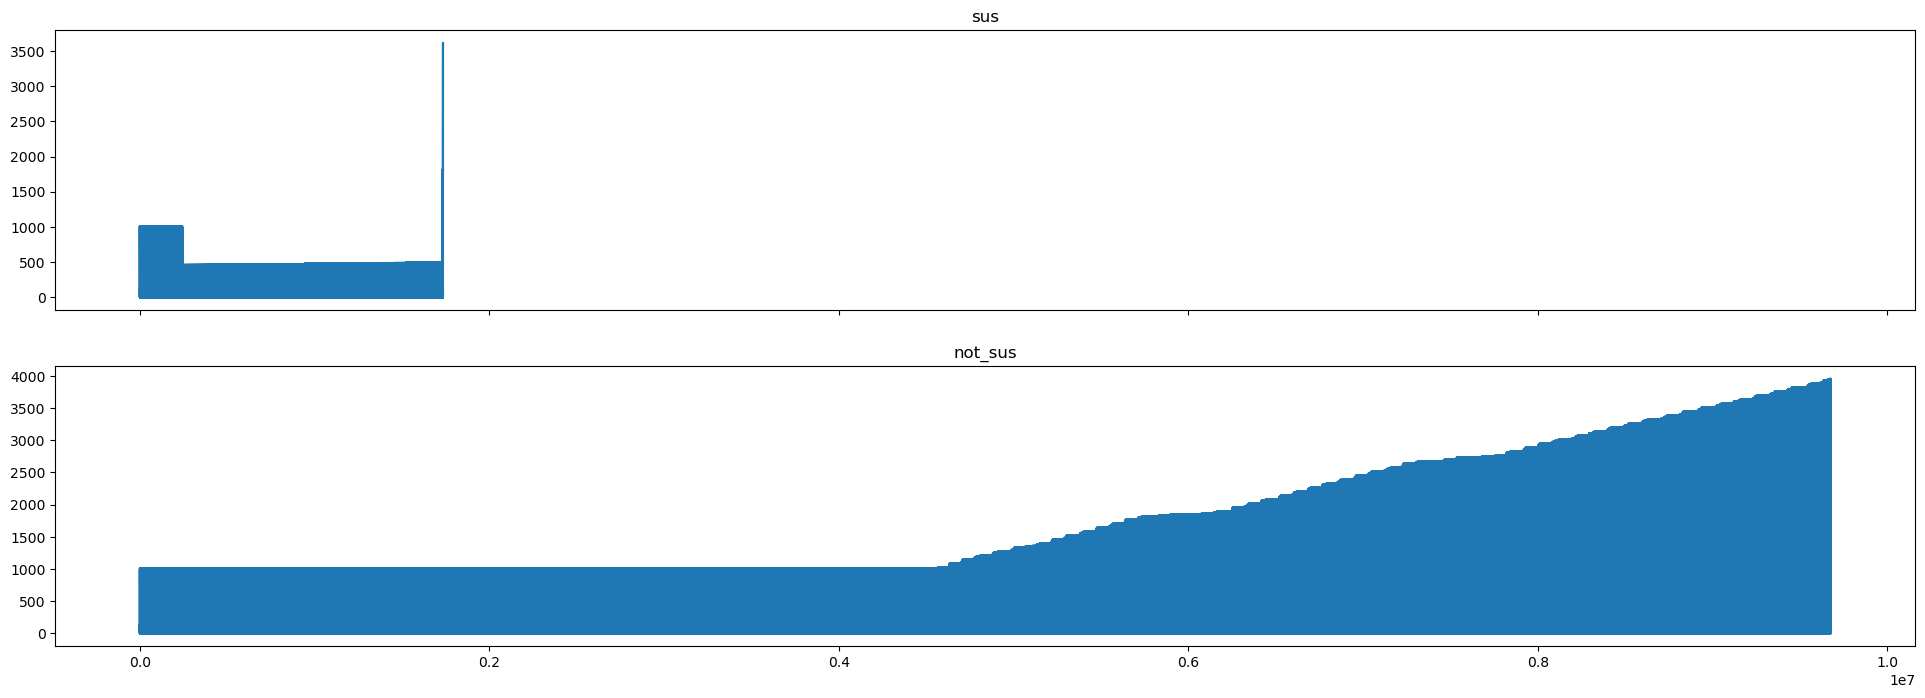

In [40]:
fig, ax = plt.subplots(2,figsize=(24, 8), sharex=True)

ax[0].set_title('sus')
ax[0].plot(sus)

ax[1].set_title('not_sus')
ax[1].plot(notsus)

In [42]:
m = 2000
profile_sus_sus = stumpy.gpu_stump(sus['centroid'], m)[:, 0].astype(float)

In [ ]:
profile_sus_notsus = stumpy.gpu_stump(sus['centroid'].astype(float), m, notsus['centroid'].astype(float), ignore_trivial=False)[:, 0].astype(float)

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data={'Sus-Sus-self':profile_sus_sus,'profile_Sus_NotSus':profile_sus_notsus}, ax=ax)

In [ ]:
profile_diff = profile_sus_notsus - profile_sus_sus

In [ ]:
profile_diff

In [ ]:
worst_matches = np.argpartition(profile_diff,-10)[-10:]

In [ ]:
worst_matches

In [ ]:
sus_shapelets = []
notsus_shapelets = []

for idx in worst_matches:
    sus_shapelet = sus_part['centroid'][idx:idx+m]    
    sus_shapelets.append(sus_shapelet)

# Building a Shapelet Based Model

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
dataset.shape

In [ ]:
dataset = dataset.head(200000)

In [ ]:
X = dataset[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]

In [ ]:
y = dataset['sus']

In [ ]:
reference_shapelet.head

In [ ]:
X_train.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
def get_shapelet_distance(shapelet, train):
    X = []
    for s, sample in enumerate(train):
        D = stumpy.mass(shapelet, sample)
        X.append(D.min())
    
    return np.array(X).reshape(-1,1)

In [ ]:
X_train.values.astype('float64').shape

In [ ]:
sus_shapelet_part = sus_shapelet.head(7)

In [ ]:
sus_shapelet_part.values

In [ ]:
reference_shapelet = sus_shapelet_part.values

In [ ]:
X_train_dist = get_shapelet_distance(reference_shapelet, X_train.values.astype('float64'))

In [ ]:
X_test_dist = get_shapelet_distance(reference_shapelet, X_test.values.astype('float64'))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier()

model.fit(X_train_dist, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = model.predict(X_test_dist)
accuracy = accuracy_score(y_test, y_pred)

accuracy

# Model Convolutional Neural Network

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import tensorflow as tf
from keras.layers import Flatten, Dense, Input, Dropout, Conv1D, BatchNormalization, MaxPooling1D, Flatten, LSTM, Bidirectional, Embedding, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adamax

In [ ]:
random_normal_initializer = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.1, seed=51)
model1 = Sequential([Conv1D(256, 3, input_shape=(7, 1), activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dropout(0.2), Flatten(), Dense(units=128, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dense(units=1, activation='sigmoid', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer)])

model1.summary()

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False)
history1 = model1.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, batch_size=10000,callbacks=[callback])

In [ ]:
# Model evaluation
accuracy1 = model1.evaluate(X_test,y_test)
print(f"Accuracy of the second model: {(100*accuracy1[1]):.1f}%")

In [ ]:
def plot_training(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get the training and validation loss
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot the loss
    plt.figure(figsize=(8, 4))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    return(plt)

In [ ]:
plot_training(history1);

# Long Short Term Memory Network

In [ ]:
random_normal_initializer = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.1, seed=51)
model1 = Sequential([
  LSTM(32, input_shape=(7, 1), activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  Flatten(),
  Dense(units=128, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dense(units=1, activation='sigmoid', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer)
])

model1.summary()

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False)
history1 = model1.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, batch_size=10000,callbacks=[callback])



In [ ]:
# Model evaluation
accuracy1 = model1.evaluate(X_test,y_test)
print(f"Accuracy of model1: {(100*accuracy1[1]):.1f}%")

In [ ]:
plot_training(history1);